# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [ ]:
import os
from pathlib import Path
from collections import Counter

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader, WeightedRandomSampler

from torchvision import transforms, models


In [ ]:
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")
print("Path to dataset files:", path)

data_dir = Path(path)  


Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

print(device)

cuda


### Dataset Class

In [5]:
class HorseBreedsDataset(Dataset):
    PREFIX_TO_LABEL = {"01":0,"02":1,"03":2,"04":3,"05":4,"06":5,"07":6}

    LABEL_TO_NAME = {
        0: "Akhal-Teke",
        1: "Appaloosa",
        2: "Orlov Trotter",
        3: "Vladimir Heavy Draft",
        4: "Percheron",
        5: "Arabian",
        6: "Friesian",
    }

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # sorting becuse we are going to linke it with lables 
        self.image_files = sorted(
            [f for f in os.listdir(self.root_dir)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        )

        # stop early if folder empty
        if len(self.image_files) == 0:
            raise ValueError(f"No images found inside: {self.root_dir}")

        self.labels = self.load_labels()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.retrieve_image(idx) # return a PIL image 
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def retrieve_image(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)

        with Image.open(img_path) as img:
            return img.convert("RGB")

    def load_labels(self):
        labels = []
        for fname in self.image_files:
            prefix = fname[:2]
            labels.append(self.PREFIX_TO_LABEL[prefix])
        return labels

    def get_label_description(self, label):
        return self.LABEL_TO_NAME[label]


In [6]:
ds = HorseBreedsDataset(path) 

print("Total samples:", len(ds))

image, label = ds[0]

print("Label index:", label)
print("Label name :", ds.get_label_description(label))
print("Image type :", type(image))

Total samples: 670
Label index: 0
Label name : Akhal-Teke
Image type : <class 'PIL.Image.Image'>


### Split the data into train val, and test set (starified)

In [7]:
indices = list(range(len(ds)))
labels = ds.labels  

# 70% train, 15% val, 15% test
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# split temp into val/test equally (15% / 15%)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,
    random_state=42,
    stratify=temp_labels
)


### Transforms

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(256), # Keeps the aspect ratio
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5), # randomly flips the image left ↔ right

    transforms.ToTensor(),

    transforms.Normalize(mean=mean, std=std),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [9]:
train_ds = Subset(HorseBreedsDataset(path, transform=train_transform), train_idx)
val_ds = Subset(HorseBreedsDataset(path, transform=val_test_transform), val_idx)
test_ds = Subset(HorseBreedsDataset(path, transform=val_test_transform), test_idx)

print("Train:", len(train_ds))
print("Val  :", len(val_ds))
print("Test :", len(test_ds))

Train: 469
Val  : 100
Test : 101


In [10]:
def subset_label_counts(subset):
    return Counter(subset.dataset.labels[i] for i in subset.indices)

print("Train dist:", subset_label_counts(train_ds))
print("Val dist  :", subset_label_counts(val_ds))
print("Test dist :", subset_label_counts(test_ds))

Train dist: Counter({0: 86, 5: 85, 6: 84, 2: 75, 1: 74, 4: 39, 3: 26})
Val dist  : Counter({0: 18, 6: 18, 5: 18, 2: 16, 1: 15, 4: 9, 3: 6})
Test dist : Counter({5: 19, 0: 19, 6: 18, 2: 16, 1: 16, 4: 8, 3: 5})


In [11]:
train_labels = [train_ds.dataset.labels[i] for i in train_ds.indices]

class_counts = Counter(train_labels)
print("Train counts:", class_counts)

class_weights = {c: 1.0 / count for c, count in class_counts.items()} # give higher whites to smaller class

sample_weights = [class_weights[y] for y in train_labels]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights, # probability of each sample being chosen
    num_samples=len(sample_weights), # how many samples per epoch
    replacement=True # same image can appear multiple times in one epoch      
)

Train counts: Counter({0: 86, 5: 85, 6: 84, 2: 75, 1: 74, 4: 39, 3: 26})


### Create Dataloader objects

In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=sampler)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


#### Display some images

In [ ]:
def visual_exploration(dataset, num_rows=2, num_cols=4, mean=None, std=None):
    total_samples = num_rows * num_cols
    indices = np.random.choice(len(dataset), total_samples, replace=False)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = np.array(axes).reshape(-1)  # flatten

    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        name = dataset.get_label_description(label)

        if isinstance(image, torch.Tensor):
            img_show = image.detach().cpu()

            if mean is not None and std is not None:
                mean_t = torch.tensor(mean).view(3, 1, 1)
                std_t  = torch.tensor(std).view(3, 1, 1)
                img_show = img_show * std_t + mean_t
                img_show = img_show.clamp(0, 1)

            h, w = img_show.shape[1], img_show.shape[2]
            img_show = img_show.permute(1, 2, 0).numpy()
        else:
            w, h = image.size
            img_show = image

        ax.imshow(img_show)
        ax.set_title(f"Index: {idx}\nLabel: {label} - {name}\nSize: {h}x{w}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


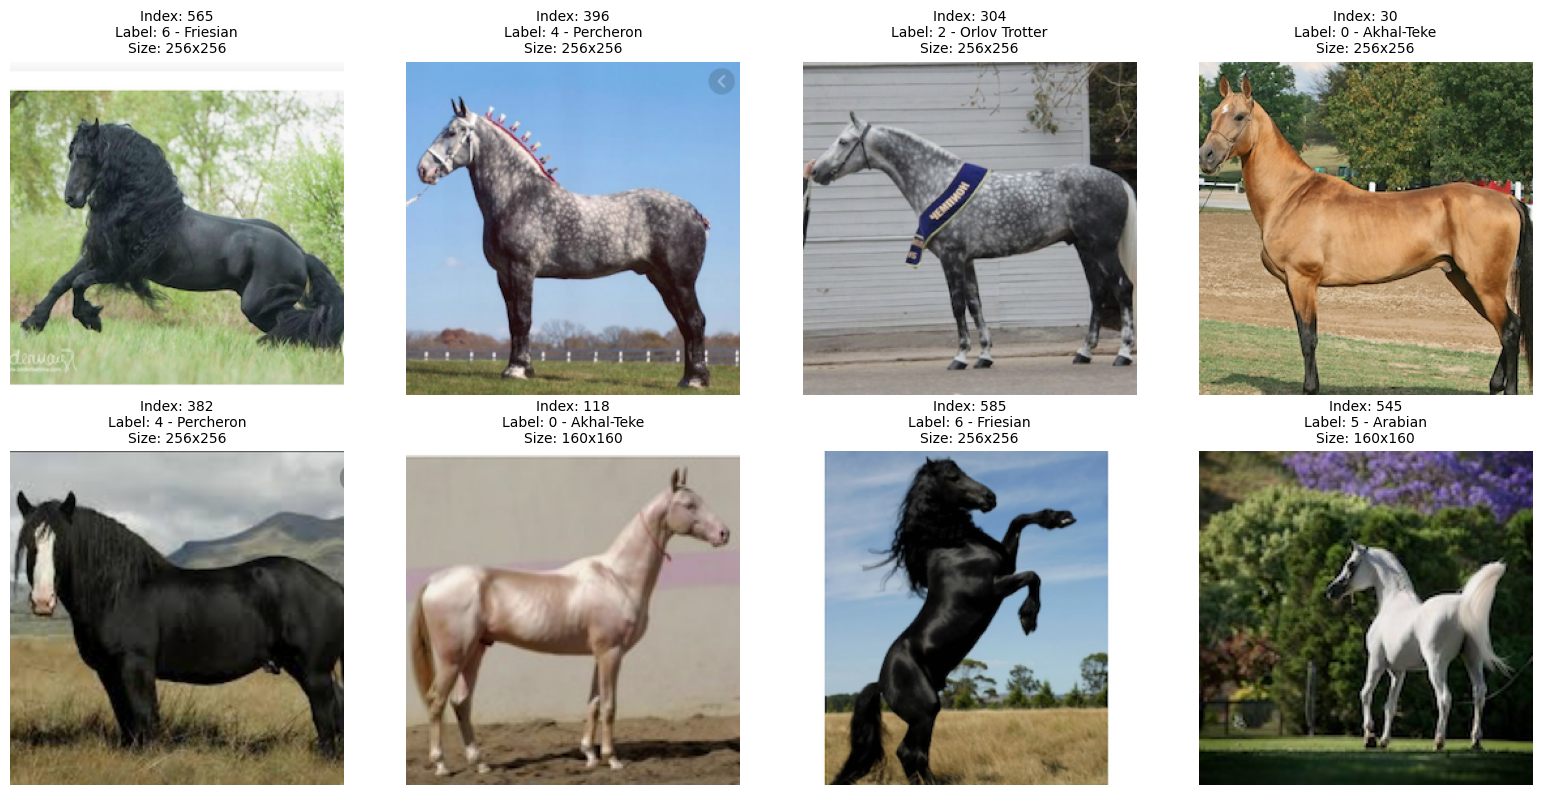

In [ ]:
# data that did not transformed yet
visual_exploration(ds, num_rows=2, num_cols=4, mean=mean, std=std)


### Define Model 

In [15]:
weights = models.EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)

print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### define Loss and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

#### Build one_epoch_training function loop 

In [ ]:
def one_epoch_training(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    for images, labels in loader: # Go through every batch in the training dataset once
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(all_labels)
    epoch_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    epoch_f1  = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1



#### Build one_epoch_validation function loop 

In [ ]:
@torch.no_grad()
def one_epoch_validation(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0) # the total loss of all images

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(all_labels)
    epoch_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item() # computed over whole epoch
    epoch_f1  = f1_score(all_labels, all_preds, average="macro") # needs all predictions

    return epoch_loss, epoch_acc, epoch_f1

In [25]:
train_loss, train_acc, train_f1 = one_epoch_training(
    model=model,
    loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

print(f"Train loss: {train_loss:.4f}")
print(f"Train acc : {train_acc:.4f}")
print(f"Train f1 : {train_f1:.4f}")


Train loss: 1.1902
Train acc : 0.7122
Train f1 : 0.5761


In [29]:
val_loss, val_acc, val_f1 = one_epoch_validation(
    model=model,
    loader=val_loader,
    criterion=criterion,
    device=device
)

print(f"Val loss: {val_loss:.4f}")
print(f"Val acc : {val_acc:.4f}")
print(f"val f1 : {val_f1:.4f}")


Val loss: 0.3010
Val acc : 0.9100
val f1 : 0.9087


### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


In [31]:
epochs = 10
best_val_f1 = 0.0
best_model_path = "best_model_f1.pt"

train_losses, train_accs, train_f1s = [], [], []
val_losses, val_accs, val_f1s = [], [], []

for epoch in range(1, epochs + 1):
    train_loss, train_acc, train_f1 = one_epoch_training(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device
    )

    val_loss, val_acc, val_f1 = one_epoch_validation(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=device
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch {epoch:02d}/{epochs} | "
        f"Train loss={train_loss:.4f}, acc={train_acc:.4f}, f1={train_f1:.4f} | "
        f"Val loss={val_loss:.4f}, acc={val_acc:.4f}, f1={val_f1:.4f}"
    )

    # Save the best model based on f1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved (val_f1={best_val_f1:.4f})")

print("\nTraining finished.")
print("Best Validation F1-score:", best_val_f1)


Epoch 01/10 | Train loss=0.1427, acc=0.9552, f1=0.9525 | Val loss=0.2843, acc=0.9000, f1=0.8996
Best model saved (val_f1=0.8996)
Epoch 02/10 | Train loss=0.1282, acc=0.9659, f1=0.9621 | Val loss=0.3176, acc=0.9000, f1=0.8996
Epoch 03/10 | Train loss=0.1557, acc=0.9552, f1=0.9500 | Val loss=0.3530, acc=0.8700, f1=0.8619
Epoch 04/10 | Train loss=0.1315, acc=0.9595, f1=0.9580 | Val loss=0.3012, acc=0.9100, f1=0.9088
Best model saved (val_f1=0.9088)
Epoch 05/10 | Train loss=0.1318, acc=0.9638, f1=0.9642 | Val loss=0.3073, acc=0.8900, f1=0.8865
Epoch 06/10 | Train loss=0.1182, acc=0.9638, f1=0.9633 | Val loss=0.3004, acc=0.8800, f1=0.8707
Epoch 07/10 | Train loss=0.1065, acc=0.9638, f1=0.9629 | Val loss=0.2811, acc=0.8900, f1=0.8920
Epoch 08/10 | Train loss=0.1355, acc=0.9595, f1=0.9528 | Val loss=0.2783, acc=0.8900, f1=0.8892
Epoch 09/10 | Train loss=0.1202, acc=0.9595, f1=0.9557 | Val loss=0.2949, acc=0.8900, f1=0.8880
Epoch 10/10 | Train loss=0.0811, acc=0.9808, f1=0.9755 | Val loss=0.28

### test the model on test set

In [32]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)
model.eval()

print("Best model loaded for test evaluation")

Best model loaded for test evaluation


In [33]:
@torch.no_grad()
def test_model(model, loader, criterion, device):
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(all_labels)
    test_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    test_f1 = f1_score(all_labels, all_preds, average="macro")

    return test_loss, test_acc, test_f1


In [34]:
test_loss, test_acc, test_f1 = test_model(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device
)

print(f"test loss: {test_loss:.4f}")
print(f"test acc: {test_acc:.4f}")
print(f"test f1: {test_f1:.4f}")

test loss: 0.4422
test acc: 0.8713
test f1: 0.8624


### show some predictions with the images

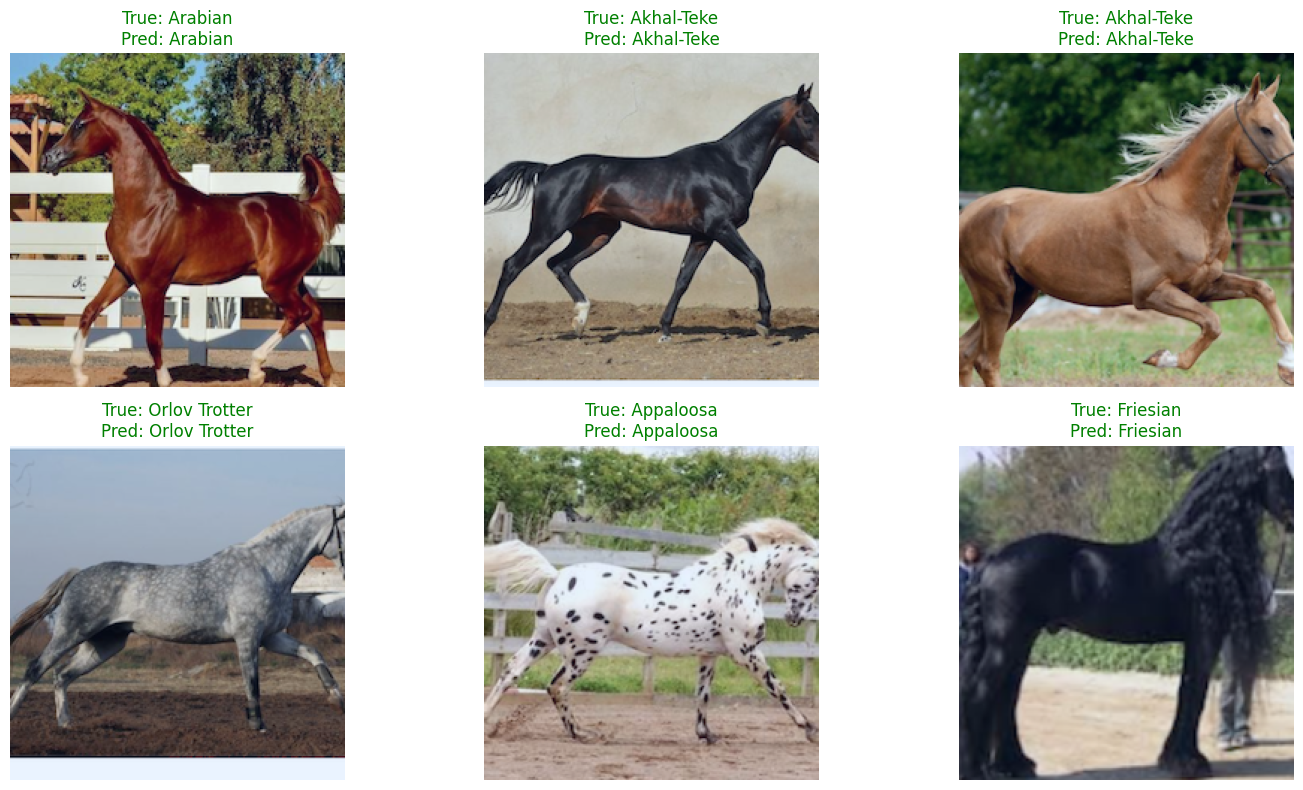

In [ ]:
model.eval()

def show_predictions(model, dataset, device, num_images=6):
    plt.figure(figsize=(15, 8))
    shown = 0

    for idx in range(len(dataset)):
        image, true_label = dataset[idx]

        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            pred_label = outputs.argmax(dim=1).item()

        img = image.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())  

        plt.subplot(2, 3, shown + 1)
        plt.imshow(img)
        plt.axis("off")

        true_name = dataset.dataset.get_label_description(true_label)
        pred_name = dataset.dataset.get_label_description(pred_label)

        title_color = "green" if true_label == pred_label else "red"
        plt.title(
            f"True: {true_name}\nPred: {pred_name}",
            color=title_color
        )

        shown += 1
        if shown == num_images:
            break

    plt.tight_layout()
    plt.show()

show_predictions(model, test_ds, device, num_images=6)


### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

In [46]:
import plotly.express as px
import pandas as pd

epochs = list(range(1, len(train_losses) + 1))

df_loss = pd.DataFrame({
    "Epoch": epochs,
    "Train Loss": train_losses,
    "Validation Loss": val_losses
})

fig_loss = px.line(
    df_loss,
    x="Epoch",
    y=["Train Loss", "Validation Loss"],
    markers=True,
    title="Training vs Validation Loss"
)

fig_loss.show()

In [45]:
df_acc = pd.DataFrame({
    "Epoch": epochs,
    "Train Accuracy": train_accs,
    "Validation Accuracy": val_accs
})

fig_acc = px.line(
    df_acc,
    x="Epoch",
    y=["Train Accuracy", "Validation Accuracy"],
    markers=True,
    title="Training vs Validation Accuracy"
)

fig_acc.show()


In [47]:
epochs = list(range(1, len(train_f1s) + 1))

df_f1 = pd.DataFrame({
    "Epoch": epochs,
    "Train F1": train_f1s,
    "Validation F1": val_f1s
})

fig_f1 = px.line(
    df_f1,
    x="Epoch",
    y=["Train F1", "Validation F1"],
    markers=True,
    title="Training vs Validation F1-score (Macro)"
)

fig_f1.update_layout(
    yaxis_title="F1-score",
    template="plotly_white",
    hovermode="x unified"
)

fig_f1.show()


The model shows effective convergence, with decreasing training loss and stable validation loss across epochs. Training accuracy reaches approximately 98%, while validation accuracy stabilizes around 90–91%, indicating good generalization to unseen data. A small gap between training and validation performance suggests mild overfitting, which is expected given the limited dataset size and transfer learning setup. The macro F1-score further confirms strong and balanced classification across all horse breeds, with validation F1 remaining high and stable around 0.90–0.91, demonstrating robust performance despite class imbalance.

### Load the model

In [ ]:
def create_model(num_classes, device):
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(device)

In [50]:
best_model_path = "best_model_f1.pt"  

model = create_model(num_classes=7, device=device)
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()
print("Best model loaded successfully")

Best model loaded successfully
